In [56]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared,ConstantKernel as C
from sklearn.metrics import mean_squared_error
import joblib
from datetime import datetime, timedelta

# Read data
#df = pd.read_csv(r'D:\Bachelor of Computer Science (Artificial Intelligence)\FYP\src\Weekly_Average_FoodWaste.csv')
df = pd.read_csv(r'Weekly_Average_FoodWaste.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

def gp_regressor(df_input,length_rbf,length_mat,nu_mat,ratio,category,savefile):

    # Define the chosen category for plotting
    df = df_input
    chosen_category = category

    # Filter the data for the chosen category
    selected_columns = ['Date', chosen_category]
    filtered_data = df[selected_columns]
    
    split_ratio = ratio # 0.97 ,0.93 = 2 points (test data)
    split_index = int(len(filtered_data) * split_ratio)
    df_train = filtered_data[:split_index+1]
    df_test = filtered_data[split_index:]

    start = filtered_data['Date'].min()
    end = filtered_data['Date'].max()
    range_datetime = (end - start).days

    # Normalize date and waste variables
    reference_date = datetime(2023, 1, 1)
    normalized_date = (df_train['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
    normalized_waste = df_train[chosen_category].values.reshape(-1, 1) / np.max(filtered_data[chosen_category])
    X = normalized_date
    y = normalized_waste    

    # Normalize date and waste variables
    normalized_date_range = (df_test['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
    normalized_waste_range = df_test[chosen_category].values.reshape(-1, 1) / np.max(df_train[chosen_category])

    X_train_ =  normalized_date
    X_test_ =  normalized_date_range


    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Gaussian stuff starts here 

    # Define different kernels
    kernel_rbf = RBF(length_scale=length_rbf ) #+ WhiteKernel(noise_level=10)
    kernel_matern = Matern(length_scale=length_mat, nu=nu_mat ) #length_scale=2, nu=1.05, sigma=1 / length_scale=2.4, nu=1.03, sigma=2 / length_scale=2.4, nu=5 , split = 0.97
    kernel_combined = kernel_rbf + kernel_matern


    # Create Gaussian Process with different kernels
    model = GaussianProcessRegressor(kernel=kernel_combined, n_restarts_optimizer=10)

    print(f'Xshape:{X.shape}, yshape:{y.shape}')

    # Fit the Gaussian Processes for the current category
    model.fit(X, y)
    model_params = model.get_params()

    print('kernel is ',model.kernel_)

    #prediction for train data
    start_date = df_train['Date'].min()
    end_date =   df_train['Date'].max() 
    date_train = pd.date_range(start=start_date, end=end_date, freq='D')

    # Normalize the date range
    normalized_date_train = (date_train - reference_date).days / range_datetime
    X_train = normalized_date_train.values.reshape(-1, 1)

    #---------------------------------------------------------------------------
    # Make predictions for the date range using the GP model
    y_pred_train, sigma_range_train = model.predict(X_train, return_std=True)

    # Denormalize the predicted wastes
    predicted_waste_train = y_pred_train * np.max(filtered_data[chosen_category])

    ###predict for test data
    start_dates = df_test['Date'].min()
    end_dates =   df_test['Date'].max()+ timedelta(days=30)
    date_test = pd.date_range(start=start_dates, end=end_dates, freq='D')

    # Normalize the date range
    normalized_date_test = (date_test - reference_date).days / range_datetime
    X_test = normalized_date_test.values.reshape(-1, 1)

    # Make predictions for the date range using the GP model
    y_pred_test, sigma_range_test = model.predict(X_test, return_std=True)

    # Denormalize the predicted wastes
    predicted_waste_test = y_pred_test * np.max(filtered_data[chosen_category])

    #Set the confidence interval (shah)
    #w = 2
    w = 2
    alpha = 0.2 #0.2

    # Visualization
    #plt.plot(filtered_data['Date'], filtered_data[chosen_category], marker='o' ,c='blue', label='Actual Waste')
    plt.scatter(filtered_data['Date'], filtered_data[chosen_category],c='blue', label='Actual Waste')
    plt.plot(date_train, predicted_waste_train, 'r', label='Predicted Waste (Train)')
    plt.plot(date_test, predicted_waste_test, c='green', markersize=8, label='Predicted Waste (Test)')
    plt.fill_between(
        date_train.ravel(),
        predicted_waste_train - w * sigma_range_train, 
        predicted_waste_train + w * sigma_range_train, 
        alpha=alpha, 
        color='y')
    plt.fill_between(
        date_test.ravel(),
        predicted_waste_test - w * sigma_range_test, 
        predicted_waste_test + w * sigma_range_test, 
        alpha=alpha,
        color='b',
        label=r"95% confidence interval")
    plt.xlabel('Date')
    plt.ylabel(chosen_category)
    plt.title(f'Prediction waste for {chosen_category}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    
    if savefile:
        filepath= 'C:\\Users\\shahr\\code\\FYP2023\\nutrimatch\\Figure\\' + chosen_category +'_fit' + '.png'
        plt.savefig(filepath,dpi=300)
    
    plt.show()

    return model

## Log marginal likelihood

In [57]:

def log_marginal_likelihood(model,chosen_category,savefile):
    from matplotlib.colors import LogNorm

    length_scale_rbf = np.logspace(-2, -1, num=50)
    length_scale_matern = np.logspace(-2, -1, num=50)
    length_scale_rbf_grid, length_scale_matern_grid = np.meshgrid(length_scale_rbf, length_scale_matern)

    log_marginal_likelihood = [
        model.log_marginal_likelihood(theta=np.log([scale, noise])) #Shah-change here
        #model.log_marginal_likelihood(theta=None))
        for scale, noise in zip(length_scale_rbf_grid.ravel(), length_scale_rbf_grid.ravel())
    ]
    log_marginal_likelihood = np.reshape(
        log_marginal_likelihood, newshape=length_scale_matern_grid.shape
    )


    vmin, vmax = (-log_marginal_likelihood).min(), 50
    level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
    plt.contour(
        length_scale_rbf_grid,
        length_scale_matern_grid,
        -log_marginal_likelihood,
        levels=level,
        norm=LogNorm(vmin=vmin, vmax=vmax),
    )
    plt.colorbar()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("length_scale_rbf")
    plt.ylabel("length_scale_matern")
    plt.title("Log-marginal-likelihood")
    

    
    if savefile:
        filepath= 'C:\\Users\\shahr\\code\\FYP2023\\nutrimatch\\Figure\\' + chosen_category +'_lml' + '.png'
        plt.savefig(filepath,dpi=300)
    
    plt.show()

    #print(f"Initial: {kernel_combined}\nOptimum: {model.kernel_} ")
    print(f"Optimum: {model.kernel_} ")
    print(f"Negative Log-Marginal-Likelihood evaluate at kernel_theta :{model.kernel_.theta} -->{model.log_marginal_likelihood(model.kernel_.theta)}")
    print('---------------------------------')
    print(f"kernel theta:{model.kernel_.theta}")
    exp_theta = np.exp(model.kernel_.theta)
    print(f"\nexp kernel theta :{exp_theta}")

Xshape:(37, 1), yshape:(37, 1)


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel is  RBF(length_scale=0.0298) + Matern(length_scale=1.01e+03, nu=5.4)


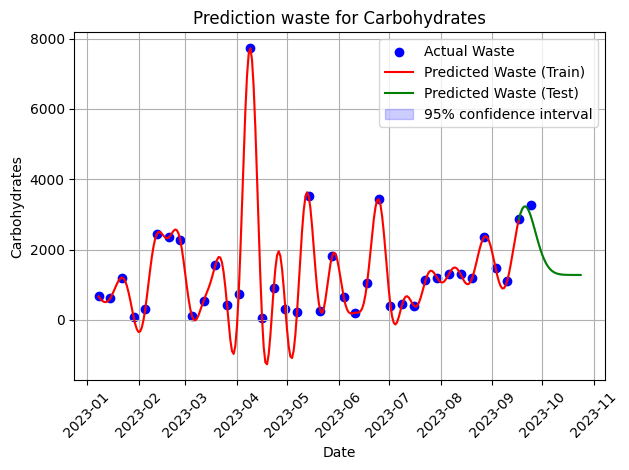

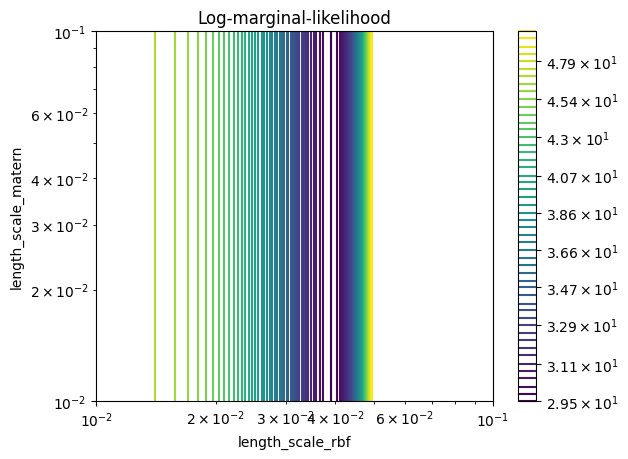

Optimum: RBF(length_scale=0.0298) + Matern(length_scale=1.01e+03, nu=5.4) 
Negative Log-Marginal-Likelihood evaluate at kernel_theta :[-3.51286017  6.91548664] -->-25.287988990435167
---------------------------------
kernel theta:[-3.51286017  6.91548664]

exp kernel theta :[2.98115263e-02 1.00776132e+03]


In [58]:
# Carb
category = 'Carbohydrates'
gp_model = gp_regressor(df,20,2.15,5.4,0.97,category,savefile=True)


log_marginal_likelihood(gp_model,category,savefile=True)
#filepath= 'C:\\Users\\shahr\\code\\FYP2023\\nutrimatch\\Figure\\' + category +'_lml' + '.png'
#plt.savefig(filepath,dpi=300)


Xshape:(37, 1), yshape:(37, 1)


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel is  RBF(length_scale=4.93e+03) + Matern(length_scale=0.0762, nu=1.58)


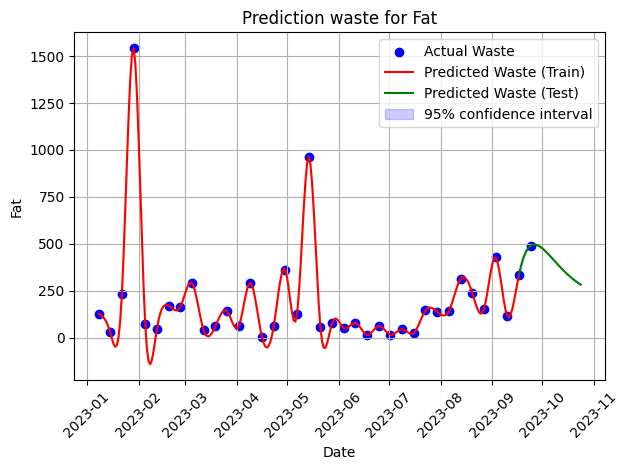

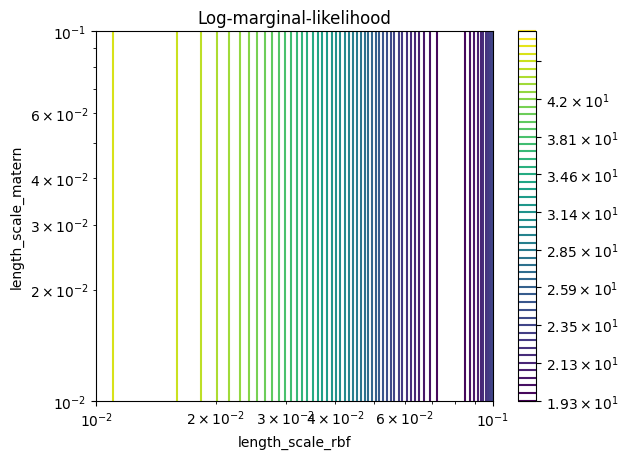

Optimum: RBF(length_scale=4.93e+03) + Matern(length_scale=0.0762, nu=1.58) 
Negative Log-Marginal-Likelihood evaluate at kernel_theta :[ 8.50309427 -2.57495531] -->-16.08011903554592
---------------------------------
kernel theta:[ 8.50309427 -2.57495531]

exp kernel theta :[4.93000000e+03 7.61572263e-02]


In [60]:
# Fat
category = 'Fat'
gp_model = gp_regressor(df,4.93e+03,0.0762,1.58,0.97,category,savefile=True)
log_marginal_likelihood(gp_model,category,savefile=True)

Xshape:(37, 1), yshape:(37, 1)


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel is  RBF(length_scale=0.03) + Matern(length_scale=125, nu=6)


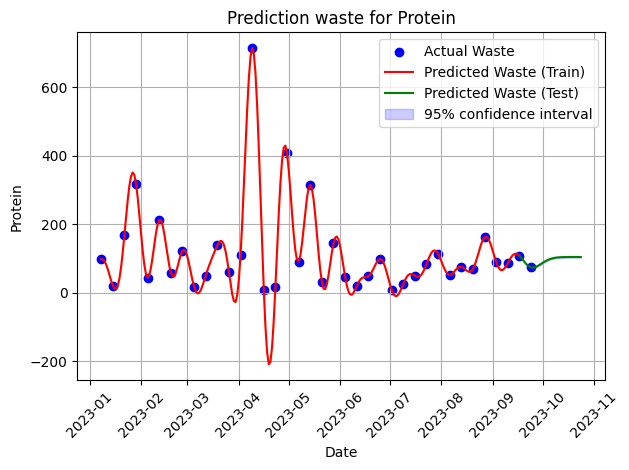

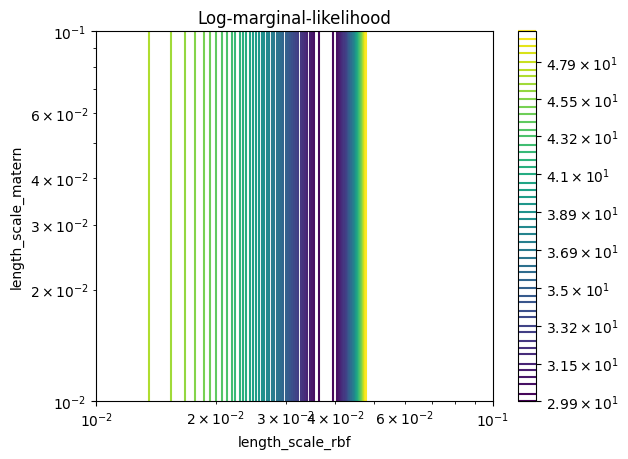

Optimum: RBF(length_scale=0.03) + Matern(length_scale=125, nu=6) 
Negative Log-Marginal-Likelihood evaluate at kernel_theta :[-3.5070351   4.82830315] -->-25.180721734925875
---------------------------------
kernel theta:[-3.5070351   4.82830315]

exp kernel theta :[2.99856873e-02 1.24998676e+02]


In [61]:
# Protein
category = 'Protein'
gp_model = gp_regressor(df,0.03,125,6,0.97,category,savefile=True)
log_marginal_likelihood(gp_model,category,savefile=True)

Xshape:(37, 1), yshape:(37, 1)


c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel is  RBF(length_scale=2.3e+03) + Matern(length_scale=0.0413, nu=5)


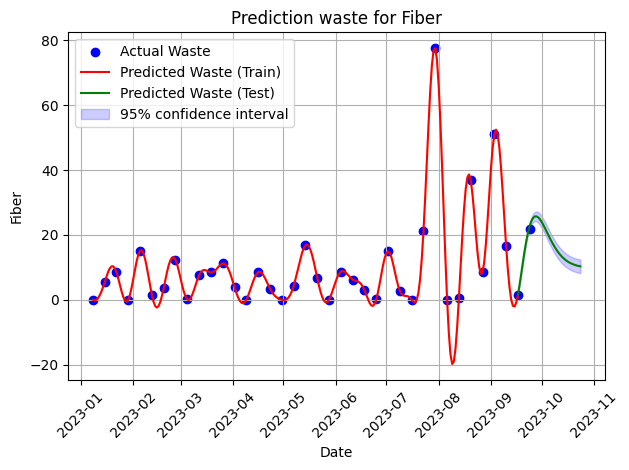

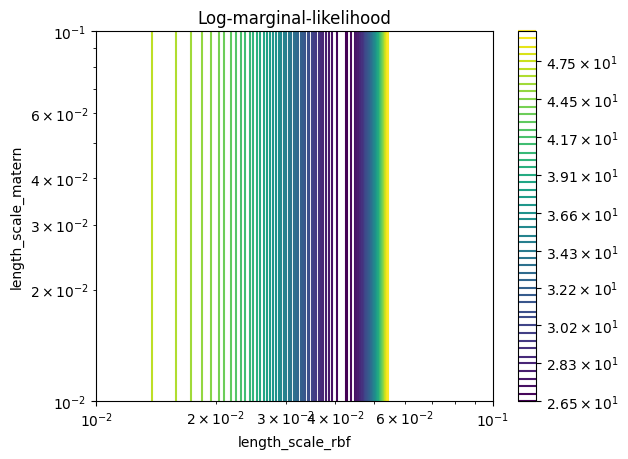

Optimum: RBF(length_scale=2.3e+03) + Matern(length_scale=0.0413, nu=5) 
Negative Log-Marginal-Likelihood evaluate at kernel_theta :[ 7.7406644  -3.18805304] -->-20.517027397101515
---------------------------------
kernel theta:[ 7.7406644  -3.18805304]

exp kernel theta :[2.3000000e+03 4.1252109e-02]


In [62]:
# Fiber
category = 'Fiber'
gp_model = gp_regressor(df,2.3e+03,0.0413,5,0.97,category,savefile=True)
log_marginal_likelihood(gp_model,category,savefile=True)